# Greedy approach to find the best set of $G$ and $J$ parameters

## Imports and functions

In [1]:
%pylab inline
import sys
sys.path.append('../code')
from notebookutils import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mse_fit(G_support, lrate, NIterations, x_target_, y_, V_hat_, Ns, B, lam, device, dtype):
    batch_size  = 100

    G_support = expandG(G_support)
    
    G_init    = np.zeros([18]) 
    J_init    = 0.1*np.tril(np.random.randn(Ns,Ns))
    J_init    = J_init + J_init.T


    J_hat_vec_ = torch.tensor(JMatToVec(J_init), device=device, dtype=dtype,  requires_grad = True)
    G_hat_ = torch.tensor(G_init, device=device, dtype=dtype,  requires_grad = True)

    opt_params = [G_hat_, J_hat_vec_]
    optimizer  = torch.optim.Adam(opt_params,lr=lrate, betas=(0.9, 0.999))

    cost = []

    for iteration in range(NIterations):

        optimizer.zero_grad()
        
        idx = np.random.randint(low=0,high=B,size=batch_size)
        
        x_fit_ = runTAP_torch(x_target_[idx,:,0], y_[idx], JVecToMat_torch(J_hat_vec_, Ns), G_hat_, V_hat_, lam.item())

        C = torch.mean((x_target_[idx,:,1:] - x_fit_[...,1:])**2)

        C.backward()
        
        # zero out gradient for zero terms in G_support
        for i in range(len(G_support)):
            G_hat_.grad[i] *= G_support[i]

        optimizer.step()

        cost.append(C.item())
    
    x_fit_ = runTAP_torch(x_target_[...,0], y_, JVecToMat_torch(J_hat_vec_, Ns), G_hat_, V_hat_, lam.item())
    
    C = torch.mean((x_target_[...,1:] - x_fit_[...,1:])**2).item()
    
    # out = {'C':C, 'G_hat_': G_hat_, 'J_hat_vec_': J_hat_vec_}
    
    return C, G_hat_, J_hat_vec_

def expandG(G_arr):
    G_arr.insert(0,0)
    G_arr.insert(8,0)
    G_arr.insert(9,0)
    G_arr.insert(17,0)
    return G_arr


def reshapeG(GVec):
    GVec = GVec.tolist()
    GVec.pop(9)
    GVec.pop(0)
    return np.array(GVec)

## Load model brain and particle EM estimates

In [3]:
noise_seed = 0
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))

brain_name = 'Ns_10_Nr_500_noiseseed_2022'

use_cuda = False
tapbrain, theta, params = loadbrain('../data/brains/' + brain_name, use_cuda)

Ns = params['Ns']
Ny = params['Ny']
Nr = params['Nr']

lam, G, J, U, V = extractParams(theta, 18, Ns, Ny, Nr)
 
# process and observation noise covariance matrices and update it in params
q_process = 1e-5
Q_process = q_process*np.eye(Ns)

# model_type -- 1: Ux + b, 0: Ux
model_type = 1 if np.any(U<0) else 0
baseline = params['baseline'] if model_type else 0

noise_seed = 0


In [4]:
# Load the inferred parameters

fname = '../data/pem-estimates/inference_Ns_10_Nr_500_noiseseed_2022_snr_5.pkl'

with open(fname,'rb') as f:
    _, params, init_params, theta_hat = pickle.load(f)
    f.close()
Q_obs = params['Q_obs']

In [5]:
# generate data from model brain
T, T_clip_rnn, T_clip = 20, 20, 10
T_low, T_high = 2, 5
yG_low, yG_high = 5, 25
B = 2000

y, x, r = generate_TAPbrain_dynamics(tapbrain,theta, params, B, T+T_clip, T_low, T_high, yG_low, yG_high, T_clip_rnn, use_cuda)

mean SNR = 5.4


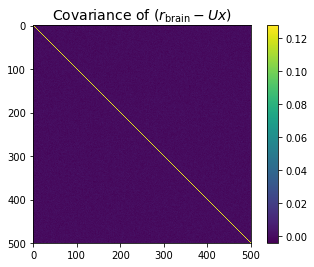

In [6]:
"""
SNR checks
"""
SNR, C_sig, C_err = computeSNR(r-baseline, x, U)
print('mean SNR = %.1f' %(SNR))

plt.imshow(C_err)
plt.title(r'Covariance of $(r_{\mathrm{brain}} - Ux)$',fontsize=14)
plt.colorbar()
plt.show()
Q_obs = np.diag(np.diag(C_err))

## Run the particle filter on neural activity using the inferred parameters

In [7]:
# Run PF on neural activity using the inferred parameters
dtype = torch.float64
use_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

Q_process_ = torch.tensor(Q_process,device=device,dtype=dtype)
Q_obs_     = torch.tensor(Q_obs,device=device,dtype=dtype)

P_process_ = Q_process_.inverse()
P_obs_     = Q_obs_.inverse()

r_   = torch.tensor(r,device=device,dtype=dtype)
y_   = torch.tensor(y,device=device,dtype=dtype)

G_hat_ = torch.tensor(theta_hat['G_hat'], device=device,dtype=dtype)
J_hat_ = torch.tensor(theta_hat['J_hat'], device=device,dtype=dtype)
U_hat_ = torch.tensor(theta_hat['U_hat'], device=device,dtype=dtype)
V_hat_ = torch.tensor(theta_hat['V_hat'], device=device,dtype=dtype)

Np = 100 # No. of particles

with torch.no_grad():
    _, x_target_, _, _ = particlefilter(G_hat_, J_hat_, U_hat_, V_hat_, lam.item(), r_ - theta_hat['b_hat'].item(), y_, P_process_, P_obs_, Np)

In [8]:
# obtain correct order of latent dynamics
U, V = extractParams(theta, 18, Ns, Ny, Nr)[3:]
PermMat = EstimatePermutation_ICA(U,theta_hat['U_hat'])
PermMat_ = torch.tensor(PermMat,device=device,dtype=dtype,requires_grad=False)

x_target_ = torch.matmul(PermMat_.t(), x_target_)

# Clip the data
x = x[...,T_clip:]
y = y[...,T_clip:]
y_ = y_[...,T_clip:]
x_target_ = x_target_[...,T_clip:]

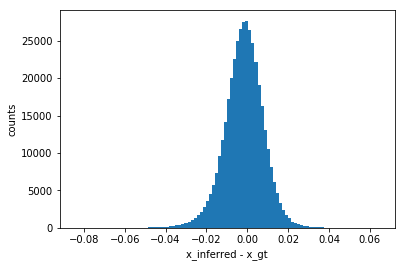

In [10]:
# histogram of inferred x - ground truth x
x_target = x_target_.data.numpy()
plt.hist((x_target - x).flatten(),100)
plt.xlabel('x_inferred - x_gt')
plt.ylabel('counts')
plt.show()

In [11]:
# change dtype to float32 
dtype = torch.float32
use_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
x_target_ = x_target_.to(dtype=dtype, device=device)
y_ = y_.to(dtype=dtype, device=device)

V_hat = np.dot(PermMat.T, theta_hat['V_hat'])
V_hat_ = torch.tensor(V_hat, device=device, dtype=dtype,  requires_grad = False)

## Greedy backward optimization

In [12]:
lrate = 1e-2
NIterations = 2500

# # initialize support of G
# G_indices = [i for i in range(16)]
# G_support = [1 for _ in range(16)]

# initialize support of G, exclude doubly quadratic terms
G_indices = [i for i in range(14)]
G_support = [1 for _ in range(14)]

full_support_length = np.sum(G_support)

best_cost = []
best_Ghat = []
best_Jhat = []
record_support = []

# first get fit with full support 

C, G_hat_, J_hat_vec_ = mse_fit(G_support.copy(), lrate, NIterations, 
                                x_target_, y_, V_hat_, Ns, B, lam, device, dtype)

best_cost.append(C)
best_Ghat.append(G_hat_.data.numpy())
best_Jhat.append(J_hat_vec_.data.numpy())
record_support.append(G_indices.copy())


for _ in range(full_support_length-1):
    
    gs_list = []  # G support list
    for idx in G_indices:
        temp = G_support.copy()
        temp[idx] = 0
        gs_list.append(temp)

    C_all = []
    G_hat_all = []
    J_hat_all = []
    
    t_st = time.time()
    for gs in gs_list:
        # print(gs)
        C, G_hat_, J_hat_vec_ = mse_fit(gs, lrate, NIterations, 
                                x_target_, y_, V_hat_, Ns, B, lam, device, dtype)
        C_all.append(C)
        G_hat_all.append(G_hat_.data.numpy())
        J_hat_all.append(J_hat_vec_.data.numpy())

    C_all = np.array(C_all)
    t_en = time.time()
    print('no. of G parameters = %d, time elapsed = %.1f mins' %(len(G_indices), (t_en-t_st)/60))   
    
    min_idx = np.argmin(C_all)
    index_to_remove = G_indices.pop(min_idx)
    G_support[index_to_remove] = 0
    
    record_support.append(G_indices.copy())
    
    best_cost.append(np.min(C_all))
    best_Ghat.append(G_hat_all[min_idx])
    best_Jhat.append(J_hat_all[min_idx])


no. of G parameters = 14, time elapsed = 18.5 mins
no. of G parameters = 13, time elapsed = 17.2 mins
no. of G parameters = 12, time elapsed = 15.8 mins
no. of G parameters = 11, time elapsed = 14.5 mins
no. of G parameters = 10, time elapsed = 13.2 mins
no. of G parameters = 9, time elapsed = 11.8 mins
no. of G parameters = 8, time elapsed = 10.6 mins
no. of G parameters = 7, time elapsed = 9.3 mins
no. of G parameters = 6, time elapsed = 8.0 mins
no. of G parameters = 5, time elapsed = 6.6 mins
no. of G parameters = 4, time elapsed = 5.3 mins
no. of G parameters = 3, time elapsed = 4.0 mins
no. of G parameters = 2, time elapsed = 2.7 mins


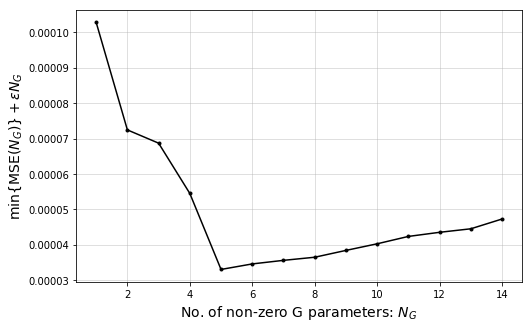

In [13]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,full_support_length+1),np.flip(np.array(best_cost), axis=0) 
         + 2e-6*np.arange(1,full_support_length+1),'k.-')

plt.xlabel(r'No. of non-zero G parameters: $N_G$',fontsize=14)
plt.ylabel(r'$\min\{\mathrm{MSE}(N_G)\} + \epsilon N_G$', fontsize=14)
plt.grid(True, alpha=0.5)

In [14]:
for k in range(len(record_support)):
    print(record_support[k])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13]
[0, 1, 4, 5, 6, 7, 8, 10, 11, 12, 13]
[0, 1, 4, 6, 7, 8, 10, 11, 12, 13]
[0, 4, 6, 7, 8, 10, 11, 12, 13]
[0, 6, 7, 8, 10, 11, 12, 13]
[0, 7, 8, 10, 11, 12, 13]
[0, 7, 8, 10, 11, 13]
[0, 7, 8, 10, 11]
[0, 8, 10, 11]
[0, 10, 11]
[0, 10]
[0]


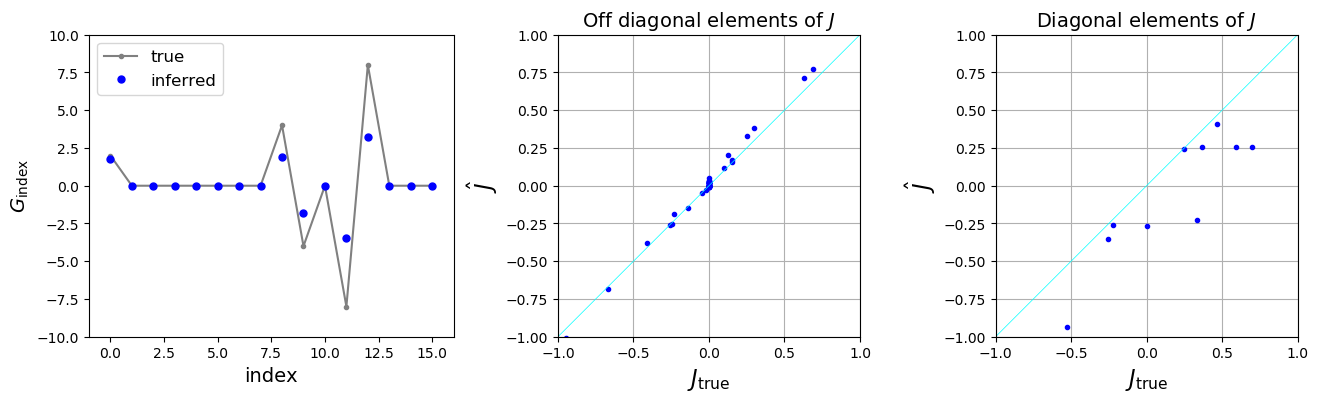

In [15]:
idx = np.argmin(np.array(best_cost) + np.flip(2e-6*np.arange(1,full_support_length+1), axis=0))

J_true_vec = JMatToVec(J)
J_hat_vec = best_Jhat[idx]
G_hat = best_Ghat[idx]

# find linear fit
b = 0
m = np.linalg.lstsq(np.expand_dims(J_true_vec,1), np.expand_dims(J_hat_vec,1))[0][0]

# normalize G_hat and J_hat
J_hat_vec_normalized = (J_hat_vec - b)/m

G_hat_normalized = G_hat*1.0
G_hat_normalized[0:9] = m*G_hat[0:9] + 2*m*b*G_hat[9:]
G_hat_normalized[9:] = (m**2)*G_hat[9:]

J1 = J - np.diag(np.diag(J))
J_Mat_normalized = JVecToMat(J_hat_vec_normalized, Ns)
J_hat1 = J_Mat_normalized - np.diag(np.diag(J_Mat_normalized))


fig, ax = plt.subplots(1,3,figsize=(16,4),dpi=100)

ax[0].plot(reshapeG(G),'.-',color='gray')
ax[0].plot(reshapeG(G_hat_normalized),'bo',markersize=5)
ax[0].set_xlabel('index',fontsize=14)
ax[0].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=14)
ax[0].legend(['true','inferred'],fontsize=12)
ax[0].axis([-1,16,-10,10])

ax[1].plot(JMatToVec(J1), JMatToVec(J_hat1),'b.')
ax[1].plot([-1,1],[-1,1],linewidth=0.5,color='cyan')
ax[1].axis('square')
ax[1].axis([-1,1,-1,1])
ax[1].grid(True)
ax[1].set_title(r'Off diagonal elements of $J$', fontsize=14)
ax[1].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[1].set_ylabel(r'$\hat{J}$',fontsize=16)

ax[2].plot(np.diag(J), np.diag(J_Mat_normalized),'b.')
ax[2].plot([-1,1],[-1,1],linewidth=0.5,color='cyan')
ax[2].axis('square')
ax[2].axis([-1,1,-1,1])
ax[2].grid(True)
ax[2].set_title(r'Diagonal elements of $J$', fontsize=14)
ax[2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
ax[2].set_ylabel(r'$\hat{J}$',fontsize=16)

plt.show()